In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import why

In [13]:
df = pd.read_csv("./data/IHDP/csv/ihdp_npci_2.csv", header=None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
df.columns = col
df = df.astype({"treatment":'int'}, copy=False)
df["ITE"] = df['mu1'] - df['mu0']
#df["outcome"] = df["treatment"] * df["y_factual"] + (1 - df["treatment"]) * df["y_cfactual"]
df["outcome"] = df["y_factual"]
df.drop(columns=["mu1", "mu0", "y_factual", "y_cfactual"], inplace=True)
ate = df["ITE"].mean()
df_train = df.drop(columns=["ITE"])
print("ATE: ", ate)
print(df_train.columns)
all_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25']

ATE:  4.050838760043126
Index(['treatment', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'outcome'],
      dtype='object')


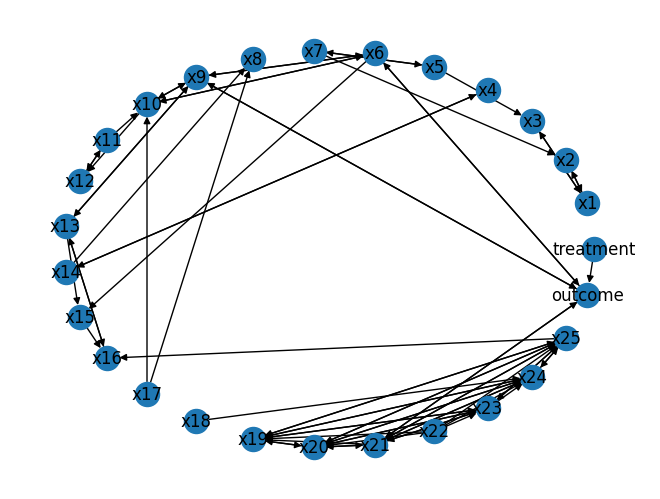

In [3]:
independence_test = why.CausalDiscovery.PearsonsCorrelation(0.05)
PC = why.CausalDiscovery.CausalDiscoveryPC(df_train, independence_test)

graph = PC.get_networkx_graph(draw=True)

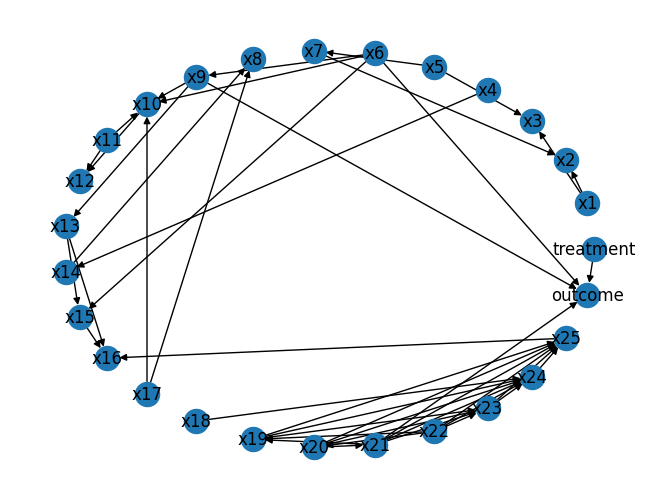

In [4]:
done = False
while not done:
    done = True
    for edge in graph.edges():
        if (edge[1], edge[0]) in graph.edges():
            graph.remove_edge(edge[1], edge[0])
            done = False
            break

while True:
    try:
        cycle = nx.find_cycle(graph)
        graph.remove_edge(cycle[0][0], cycle[0][1])
    except:
        break
nx.draw_circular(graph, with_labels=True)

In [5]:
treatment = "treatment"
outcome = "outcome"
adjustor = why.BackdoorAdjustment(graph)
adjustment_sets = adjustor.get_all_backdoor_adjustment_set(treatment, outcome, max_size=10)
if len(adjustment_sets) == 0:
    print("No causal chain found between {} and {}".format(treatment, outcome))
minimal_adjustment_set = list(adjustment_sets[0])
minimal_adjustment_set

[]

In [14]:
# COMEstimator with LinearRegression
from sklearn.linear_model import LinearRegression

estimator = why.Estimation.COMEstimator(df_train, LinearRegression())
com_linear_ate = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"COM Linear ATE: {com_linear_ate:.4f}")

estimator = why.Estimation.COMEstimator(df_train, LinearRegression())
com_linear_ate_max = estimator.estimate(treatment, outcome, all_cols)
print(f"COM Linear ATE, max adjustment set: {com_linear_ate_max:.4f}")

COM Linear ATE: 4.0814
COM Linear ATE, max adjustment set: 3.8994


In [47]:
import torch.nn
from tqdm import tqdm
# GCOMEstimator with LinearRegression
print("Empty Adjustment Set")
estimator = why.Estimation.GCOMEstimator(df, LinearRegression())
gcom_linear_ate = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"GCOM Linear ATE: {gcom_linear_ate:.4f}")

print("With an Adjustment Set")
estimator = why.Estimation.GCOMEstimator(df, LinearRegression())
gcom_linear_ate_max = estimator.estimate(treatment, outcome, all_cols)
print(f"GCOM Linear ATE: {gcom_linear_ate_max:.4f}")

class NNModel:
    def __init__(self):
        pass
    def fit(self, X, y):
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float().reshape(-1, 1)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(X.shape[1], 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 1)
        )
        optim = torch.optim.Adam(self.model.parameters(), lr=0.005)
        for _ in tqdm(range(1000), disable=True):
            optim.zero_grad()
            loss = torch.nn.functional.mse_loss(self.model(X), y)
            loss.backward()
            optim.step()
    def predict(self, X):
        X = torch.from_numpy(X).float()
        return self.model(X)[:, 0].detach().cpu().numpy()

estimator = why.Estimation.GCOMEstimator(df, NNModel())
gcom_fcn_ate_max = estimator.estimate(treatment, outcome, all_cols)
print(f"GCOM FCN ATE: {gcom_fcn_ate_max:.4f}")


Empty Adjustment Set
Warning, GCOM: No adjustment set provided, returning ate = E[Y|T=1]-E[Y|T=0]
GCOM Linear ATE: 4.0814
With an Adjustment Set
GCOM Linear ATE: 4.0568
GCOM FCN ATE: 4.0233


In [17]:
# TARNet
estimator = why.Estimation.TARNet(df)
tarnet_no_adj_set = estimator.estimate(treatment, outcome, minimal_adjustment_set)
print(f"No adj set TARNet ATE: {tarnet_no_adj_set:.4f}")

estimator = why.Estimation.TARNet(df)
tarnet_with_adj_set = estimator.estimate(treatment, outcome, all_cols, hidden_size=300)
print(f"With adj set TARNet ATE: {tarnet_with_adj_set:.4f}")

Warning, GCOM: No adjustment set provided, returning ate = E[Y|T=1]-E[Y|T=0]
No adj set TARNet ATE: 4.0814
With adj set TARNet ATE: 4.0812


In [48]:
from IPython.display import Markdown as md

table = "| Method       | Estimated ATE | Absolute Error     |\n"
table += "| :---        |    :----:   |          ---: |\n"

table += f"| COM Linear (min adj set) | {com_linear_ate:.4f} | {abs(com_linear_ate - ate):.4f} |\n"
table += f"| COM Linear (max adj set) | {com_linear_ate_max:.4f} | {abs(com_linear_ate_max - ate):.4f} |\n"
table += f"| GCOM Linear (min adj set) | {gcom_linear_ate:.4f} | {abs(gcom_linear_ate - ate):.4f} |\n"
table += f"| GCOM Linear (max adj set) | {gcom_linear_ate_max:.4f} | {abs(gcom_linear_ate_max - ate):.4f} |\n"
table += f"| GCOM FCN (max adj set) | {gcom_fcn_ate_max:.4f} | {abs(gcom_fcn_ate_max - ate):.4f} |\n"
table += f"| TARNet (max adj set) | {tarnet_with_adj_set:.4f} | {abs(tarnet_with_adj_set - ate):.4f} |\n"

md("# Evaluation\n"+table)

# Evaluation
| Method       | Estimated ATE | Absolute Error     |
| :---        |    :----:   |          ---: |
| COM Linear (min adj set) | 4.0814 | 0.0306 |
| COM Linear (max adj set) | 3.8994 | 0.1515 |
| GCOM Linear (min adj set) | 4.0814 | 0.0306 |
| GCOM Linear (max adj set) | 4.0568 | 0.0060 |
| GCOM FCN (max adj set) | 4.0233 | 0.0275 |
| TARNet (max adj set) | 4.0812 | 0.0304 |
